# Preprocessing

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Create a builder object for the Eurosat dataset
dataset_builder = tfds.builder('eurosat')

In [ ]:
# Get the dataset information
dataset_info = dataset_builder.info

In [ ]:
# Print the dataset information
dataset_info

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='/root/tensorflow_datasets/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised

In [ ]:
# string representations of all the class labels
classes = dataset_info.features["label"].names

In [ ]:
# 10 classes
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [ ]:
# Load the EuroSAT dataset
dataset = tfds.load("eurosat/rgb", split="train")

# Split the dataset into train, val, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)

# Convert the datasets to tf.data.Dataset objects
train_dataset = train_dataset.as_dataset()
val_dataset = val_dataset.as_dataset()
test_dataset = test_dataset.as_dataset()

In [ ]:
# print datapoints in train_dataset
data = np.random.rand(10,2)
train_dataset = iter(data)

for datapoint in train_dataset:
  print(datapoint)

{'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'Forest_687.jpg'>,
 'image': <tf.Tensor: shape=(64, 64, 3), dtype=uint8, numpy=
 array([[[35, 59, 71],
         [35, 59, 71],
         [36, 60, 72],
         ...,
         [32, 60, 72],
         [31, 59, 70],
         [33, 63, 73]],
 
        [[35, 59, 71],
         [34, 61, 72],
         [37, 61, 73],
         ...,
         [31, 59, 70],
         [31, 59, 70],
         [33, 63, 73]],
 
        [[37, 64, 73],
         [35, 64, 72],
         [38, 65, 74],
         ...,
         [35, 63, 74],
         [31, 59, 70],
         [32, 61, 69]],
 
        ...,
 
        [[31, 54, 70],
         [29, 55, 68],
         [32, 59, 70],
         ...,
         [33, 62, 70],
         [32, 60, 71],
         [34, 62, 73]],
 
        [[33, 59, 72],
         [32, 59, 70],
         [32, 59, 70],
         ...,
         [32, 60, 71],
         [37, 66, 74],
         [35, 65, 73]],
 
        [[34, 62, 73],
         [33, 61, 72],
         [35, 62, 73],
     

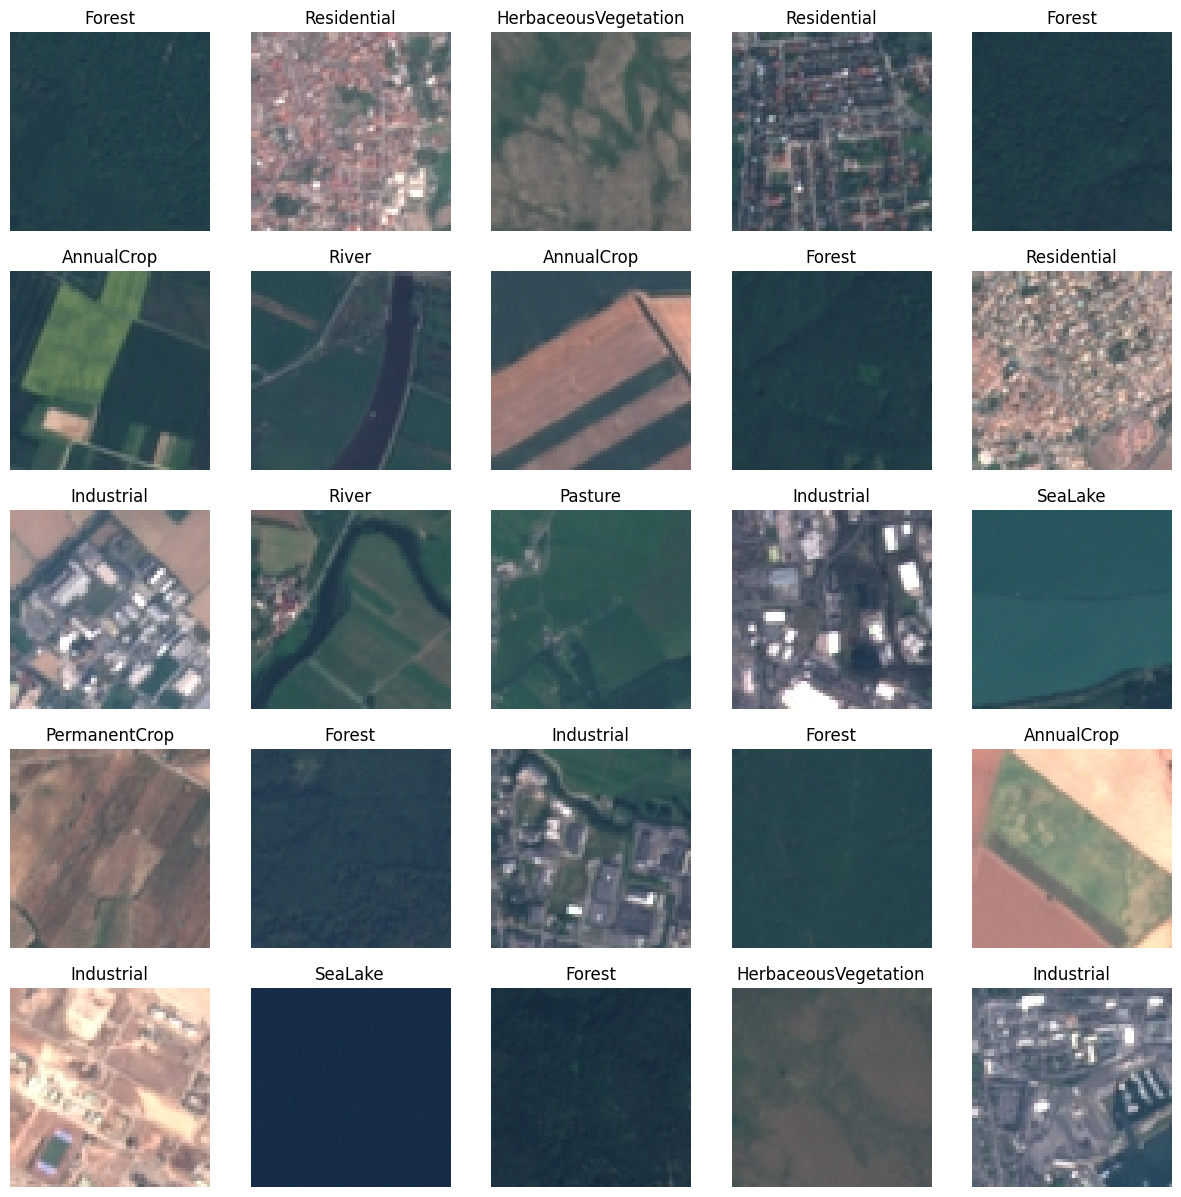

In [ ]:
import matplotlib.pyplot as plt

# Define the number of images to display
num_images = 25

# Load the Eurosat dataset
dataset = tfds.builder('eurosat')
train_dataset = dataset.as_dataset('train')

# Extract image and label data from the dataset
image_data = tfds.as_numpy(train_dataset.take(num_images))["image"]
label_data = tfds.as_numpy(train_dataset.take(num_images))["label"]

# Create a 5x5 grid of subplots
plt.figure(figsize=(15, 15))

# Iterate through the image and label data
for i in range(num_images):
  # Get the current image and label
  image = image_data[i]
  label = label_data[i]

  # Create a subplot at the current position in the grid
  ax = plt.subplot(5, 5, i+1)

  # Display the image in the subplot
  plt.imshow(image)

  # Display the label as the subplot title
  plt.title(classes[label])

  # Turn off the subplot axes
  plt.axis("off")

# Show the entire plot
plt.show()

In [ ]:
# Define the shape of the input images
IMAGE_SHAPE = [180, 180]

# Determine the number of classes based on the dataset information
NUM_CLASSES = dataset_info.features["label"].num_classes

<tf.Tensor: shape=(), dtype=float32, numpy=0.092141986>

In [ ]:
# Define the number of training epochs
NUM_EPOCHS = 6

# Define the batch size for training and testing
BATCH_SIZE = 128

# Define the buffer size for shuffling the data
BUFFER_SIZE = 1000

In [ ]:
@tf.function
def prepare_training_data(datapoint):
  """Prepares a single datapoint for training, including data augmentation."""

  # Resize the image to the desired size
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)

  # Apply random augmentation with 50% probability
  if tf.random.uniform(()) > 0.5:
    # Flip the image left-right
    input_image = tf.image.random_flip_left_right(input_image)

    # Flip the image up-down
    input_image = tf.image.random_flip_up_down(input_image)

    # Apply random brightness change
    input_image = tf.image.random_brightness(input_image, max_delta=0.3)

    # Apply random saturation change
    input_image = tf.image.random_saturation(input_image, lower=0.75, upper=1.5)

    # Apply random contrast change
    input_image = tf.image.random_contrast(input_image, lower=0.75, upper=1.5)

  # Preprocess the image for the model
  input_image = preprocess_input(input_image)

  # Return the input image and label
  return input_image, datapoint["label"]

@tf.function
def prepare_validation_data(datapoint):
  """Prepares a single datapoint for validation."""

  # Resize the image to the desired size
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)

  # Apply standard preprocessing for validation data
  input_image = preprocess_input(input_image)

  # Return the input image and label
  return input_image, datapoint["label"]

In [ ]:
# Apply the prepare_training_data function to each element of the train dataset
train = train_dataset.map(
    prepare_training_data,
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

# Apply the prepare_validation_data function to each element of the validation dataset
validation = val_dataset.map(prepare_validation_data)

# Cache the training data for faster subsequent reads
train_dataset = train.cache()

# Shuffle the training data to avoid bias
train_dataset = train_dataset.shuffle(BUFFER_SIZE)

# Batch the training data into smaller chunks for easier processing
train_dataset = train_dataset.batch(BATCH_SIZE)

# Repeat the training data indefinitely for continuous training
train_dataset = train_dataset.repeat()

# Pre-fetch data to improve performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Batch the validation data for efficient evaluation
validation_dataset = validation.batch(BATCH_SIZE)

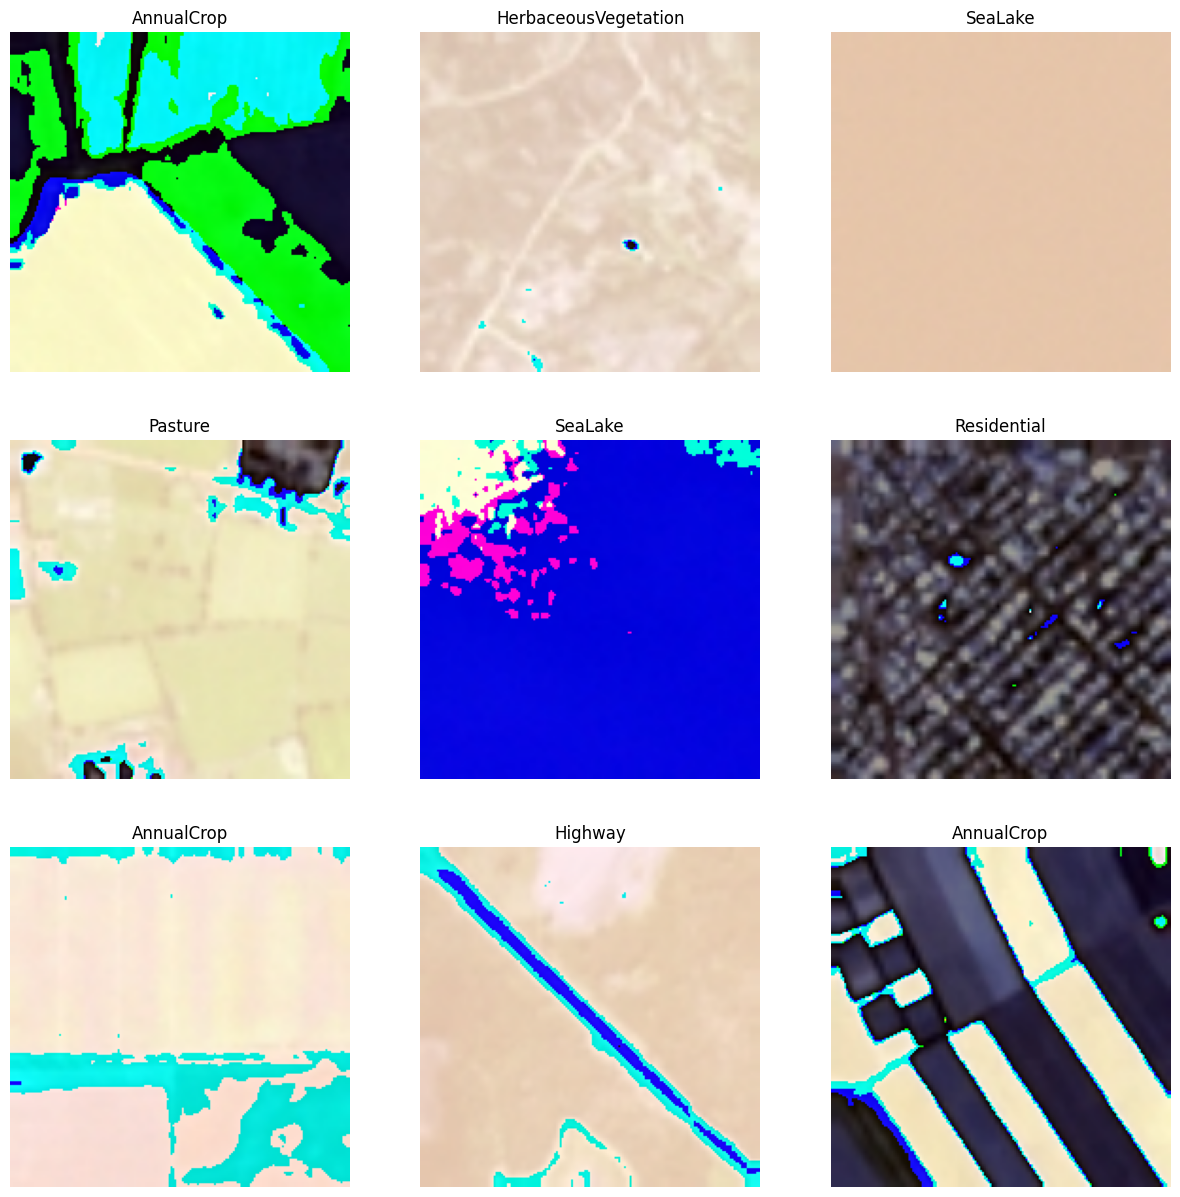

In [ ]:
# Define the number of rows and columns for the subplots
rows, cols = 3, 3

# Create a figure with a specific size
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Iterate through each subplot
for i, ax in enumerate(axes.flat):
    # Take the next datapoint from the training dataset
    datapoint = next(iter(tfds.as_numpy(train_dataset.take(1))))

    # Extract image and label
    image, label = datapoint[0][0], datapoint[1][0]

    # Convert the image to uint8 for proper display
    image = image.astype("uint8")

    # Display the image in the current subplot
    ax.imshow(image)

    # Add a title with the class name
    ax.set_title(classes[label])

    # Turn off axis labels and ticks
    ax.set_axis_off()

# Display the entire figure
plt.show()

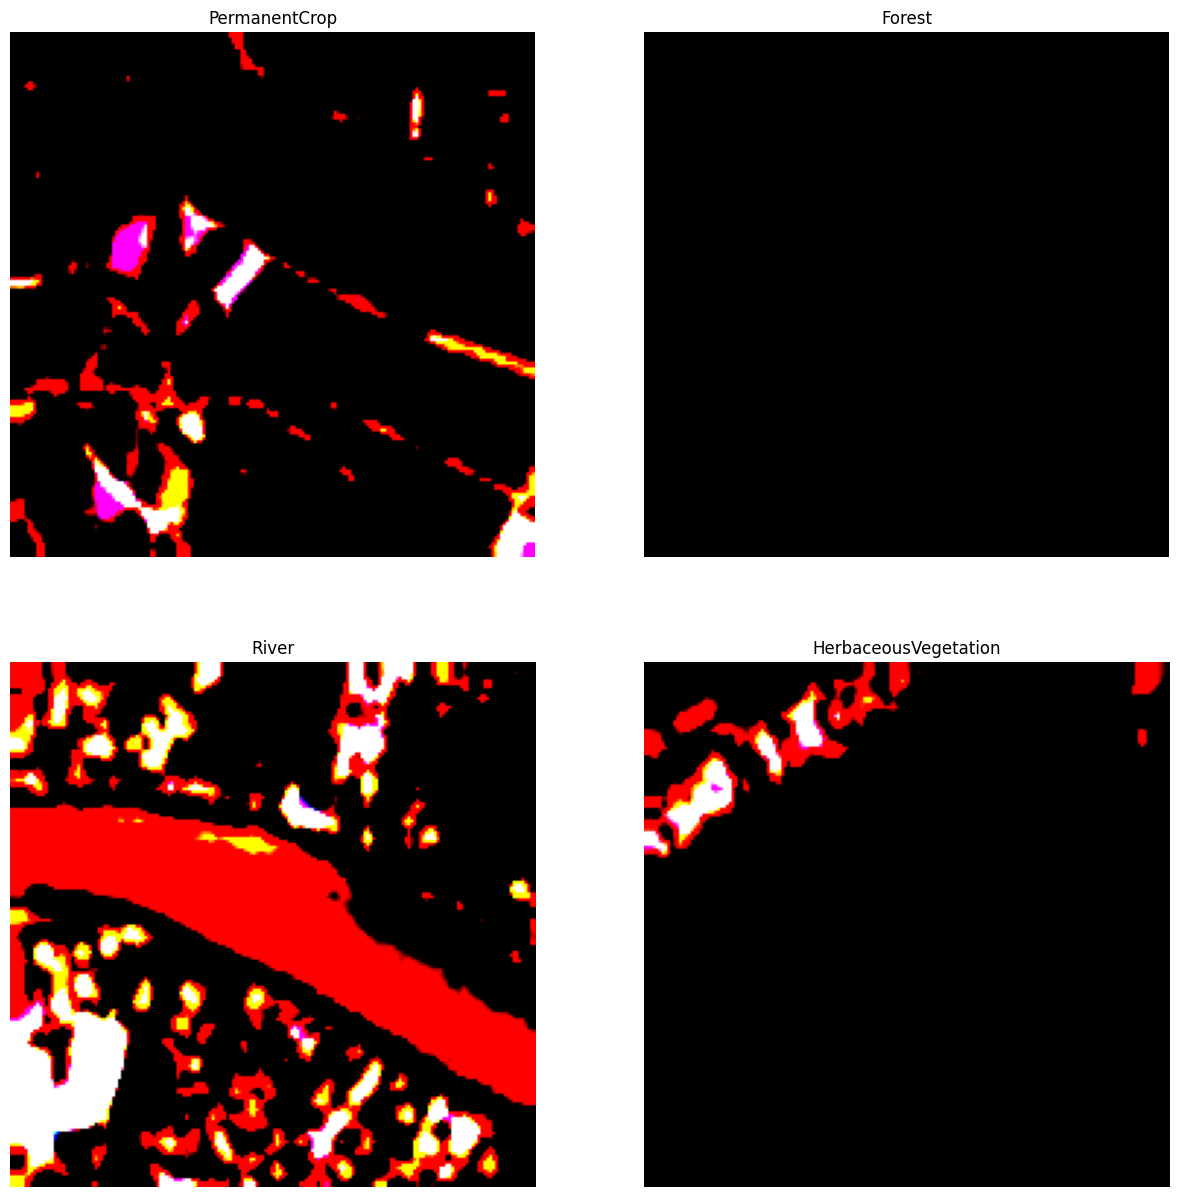

In [ ]:
# Define figure size
plt.figure(figsize=(15, 15))

# Loop through four subplots
for i in range(4):
    # Create subplot
    ax = plt.subplot(2, 2, i + 1)

    # Take one sample from the training dataset
    for datapoint in tfds.as_numpy(train_dataset.take(1)):
        # Extract image and label
        image = datapoint[0][0]
        label = classes[datapoint[1][0]]

        # Display image
        plt.imshow(image)

        # Add label and turn off axes
        plt.title(label)
        plt.axis("off")

# Show entire plot
plt.show()

# Results Without Pre-Processing

# ResNet50 Without Pre-Processing

In [11]:
# Import the ResNet50 architecture and preprocess_input function from Keras applications
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

# Create the base ResNet50 model with pre-trained weights
resnet = ResNet50(
    input_shape=IMAGE_SHAPE + [3],
    weights="imagenet",
    include_top=False  # exclude the pre-trained top layers
)

# Freeze all layers in the base model to prevent them from being updated during training
for layer in resnet.layers:
    layer.trainable = False

# Add additional layers for fine-tuning
x = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)  # average pooling over spatial dimensions
x = tf.keras.layers.Flatten()(x)  # flatten the output into a single vector
x = tf.keras.layers.Dense(512, activation="relu")(x)  # add a dense layer with 512 units and ReLU activation
prediction = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)  # output layer with NUM_CLASSES units and softmax activation

# Create the final model
model = tf.keras.models.Model(
    inputs=resnet.input,  # use the input layer of the base model
    outputs=prediction  # use the prediction layer as the model output
)

# Define the loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Define the optimizer
optimizer = tf.keras.optimizers.Adam()
# Define the metrics
metrics = ['accuracy']

# Compile the model
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics
)

STEPS_PER_EPOCH = 10
VALIDATION_STEPS = 30

# Train the model
history = model.fit(
    # Train data
    train_dataset,
    # Number of epochs to train for
    epochs=NUM_EPOCHS,
    # Number of steps per epoch (optional)
    steps_per_epoch=STEPS_PER_EPOCH,
    # Validation data
    validation_data=validation_dataset,
    # Number of validation steps per epoch (optional)
    validation_steps=VALIDATION_STEPS
)

Epoch 1/5
10/10 [==============================] - 22s 2s/step - loss: 1.9449 - accuracy: 0.3828 - val_loss: 1.5858 - val_accuracy: 0.5346
Epoch 2/5
10/10 [==============================] - 11s 1s/step - loss: 1.3744 - accuracy: 0.5875 - val_loss: 1.1802 - val_accuracy: 0.6544
Epoch 3/5
10/10 [==============================] - 13s 1s/step - loss: 1.0793 - accuracy: 0.6867 - val_loss: 0.9522 - val_accuracy: 0.7414
Epoch 4/5
10/10 [==============================] - 13s 1s/step - loss: 0.8719 - accuracy: 0.7688 - val_loss: 0.8091 - val_accuracy: 0.7779
Epoch 5/5
10/10 [==============================] - 13s 1s/step - loss: 0.7739 - accuracy: 0.7781 - val_loss: 0.7024 - val_accuracy: 0.7939


In [13]:
model.evaluate(test_dataset)

22/22 [==============================] - 7s 294ms/step - loss: 0.7168 - accuracy: 0.7919


[0.7167627215385437, 0.7918518781661987]

# VGG16 Without Pre-Processing

In [6]:
# Import necessary modules for VGG16
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Load VGG16 model with pre-trained weights from ImageNet
vgg16 = VGG16(input_shape=IMAGE_SHAPE+[3], weights='imagenet', include_top=False)

# Freeze all VGG16 layers to avoid retraining pre-trained weights
for layer in vgg16.layers:
  layer.trainable = False

# Add custom layers for global average pooling, flattening, and dense layers
# - GlobalAveragePooling2D: averages the output of all channels in the last convolutional layer
# - Flatten: converts the 3D feature map into a 1D vector
# - Dense(512, activation='relu'): adds a fully-connected layer with 512 neurons and ReLU activation
# - Dense(NUM_CLASSES, activation='softmax'): adds the output layer with NUM_CLASSES neurons and softmax activation for classification
x = tf.keras.layers.GlobalAveragePooling2D()(vgg16.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
prediction = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Create and compile the model
model = tf.keras.models.Model(inputs=vgg16.input, outputs=prediction)

# Define the loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Choose the optimizer
optimizer = "adam"

# Define the metrics to track
metrics = ["accuracy"]

# Compile the model
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Define the number of steps per epoch
STEPS_PER_EPOCH = 8

# Calculate the validation steps
VALIDATION_STEPS = int(info.splits["train"].num_examples * 0.1) // BATCH_SIZE

# Train the model
history = model.fit(
    # Train dataset
    train_dataset,
    # Number of epochs to train for
    epochs=NUM_EPOCHS,
    # Number of steps per epoch (optional)
    steps_per_epoch=STEPS_PER_EPOCH,
    # Validation dataset for monitoring progress (optional)
    validation_data=validation_dataset,
    # Number of validation steps per epoch (optional)
    validation_steps=VALIDATION_STEPS
)

Epoch 1/5
8/8 [==============================] - 31s 2s/step - loss: 3.4343 - accuracy: 0.1045 - val_loss: 2.3557 - val_accuracy: 0.1656
Epoch 2/5
8/8 [==============================] - 11s 2s/step - loss: 2.0458 - accuracy: 0.2891 - val_loss: 1.6457 - val_accuracy: 0.4528
Epoch 3/5
8/8 [==============================] - 14s 2s/step - loss: 1.4586 - accuracy: 0.5449 - val_loss: 1.2022 - val_accuracy: 0.6194
Epoch 4/5
8/8 [==============================] - 11s 2s/step - loss: 1.0883 - accuracy: 0.6582 - val_loss: 0.9300 - val_accuracy: 0.7147
Epoch 5/5
8/8 [==============================] - 13s 2s/step - loss: 0.8615 - accuracy: 0.7266 - val_loss: 0.7595 - val_accuracy: 0.7686


In [8]:
model.evaluate(test_dataset)

22/22 [==============================] - 9s 396ms/step - loss: 0.7798 - accuracy: 0.7767


[0.7797642946243286, 0.7766666412353516]

# DenseNet201 Without Pre-Processing

In [13]:
# Import the DenseNet201 model and preprocess_input function from the TensorFlow Keras applications library
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input

# Load pre-trained DenseNet201 with ImageNet weights, excluding top layer
denseNet = DenseNet201(input_shape=IMAGE_SHAPE + [3], weights="imagenet", include_top=False)

# Freeze all pre-trained layers
for layer in denseNet.layers:
  layer.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(denseNet.output)  # Global average pooling
x = Flatten()(x)  # Flatten
x = Dense(512, activation="relu")(x)  # Dense layer with 512 units and ReLU activation
prediction = Dense(NUM_CLASSES, activation="softmax")(x)  # Output layer with softmax activation

# Create the model
model = tf.keras.models.Model(inputs=denseNet.input, outputs=prediction)

# Print model summary
model.summary()

# Define the number of steps per epoch (8)
STEPS_PER_EPOCH = 8

# Calculate the number of validation steps
VALIDATION_STEPS = info.splits["train"].num_examples // BATCH_SIZE
VALIDATION_STEPS = int(VALIDATION_STEPS * 0.1)  # Use 10% of training data for validation

# Configure the training process
training_config = {
    "epochs": NUM_EPOCHS,  # Number of times to iterate over the entire training dataset
    "steps_per_epoch": STEPS_PER_EPOCH,  # Number of batches to process per epoch
    "validation_data": validation_dataset,  # Dataset to evaluate the model on during training
    "validation_steps": VALIDATION_STEPS,  # Number of batches to process for validation
}

# Train the model and store the training history
history = model.fit(train_dataset, **training_config)

Epoch 1/5
8/8 [==============================] - 35s 2s/step - loss: 2.2331 - accuracy: 0.2871 - val_loss: 1.4333 - val_accuracy: 0.4866
Epoch 2/5
8/8 [==============================] - 14s 2s/step - loss: 1.3173 - accuracy: 0.5107 - val_loss: 1.1514 - val_accuracy: 0.6038
Epoch 3/5
8/8 [==============================] - 11s 2s/step - loss: 1.0810 - accuracy: 0.6289 - val_loss: 0.9591 - val_accuracy: 0.6700
Epoch 4/5
8/8 [==============================] - 11s 2s/step - loss: 0.9518 - accuracy: 0.6787 - val_loss: 0.8396 - val_accuracy: 0.7199
Epoch 5/5
8/8 [==============================] - 11s 1s/step - loss: 0.8212 - accuracy: 0.7197 - val_loss: 0.7735 - val_accuracy: 0.7377


In [16]:
model.evaluate(test_dataset)

22/22 [==============================] - 8s 341ms/step - loss: 2.6573 - accuracy: 0.1278


[2.6573009490966797, 0.12777778506278992]

# Results With Pre-Processing

# VGG16

In [ ]:
# Import necessary modules for VGG16
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
# Load VGG16 model with pre-trained weights from ImageNet
vgg16 = VGG16(input_shape=IMAGE_SHAPE+[3], weights='imagenet', include_top=False)

# Freeze all VGG16 layers to avoid retraining pre-trained weights
for layer in vgg16.layers:
  layer.trainable = False

# Add custom layers for global average pooling, flattening, and dense layers
# - GlobalAveragePooling2D: averages the output of all channels in the last convolutional layer
# - Flatten: converts the 3D feature map into a 1D vector
# - Dense(512, activation='relu'): adds a fully-connected layer with 512 neurons and ReLU activation
# - Dense(NUM_CLASSES, activation='softmax'): adds the output layer with NUM_CLASSES neurons and softmax activation for classification
x = tf.keras.layers.GlobalAveragePooling2D()(vgg16.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
prediction = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Create and compile the model
model = tf.keras.models.Model(inputs=vgg16.input, outputs=prediction)

In [ ]:
# Define the loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Choose the optimizer
optimizer = "adam"

# Define the metrics to track
metrics = ["accuracy"]

# Compile the model
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# Define the number of steps per epoch
STEPS_PER_EPOCH = 8

# Calculate the validation steps
VALIDATION_STEPS = int(info.splits["train"].num_examples * 0.1) // BATCH_SIZE

In [ ]:
# Train the model
history = model.fit(
    # Train dataset
    train_dataset,
    # Number of epochs to train for
    epochs=NUM_EPOCHS,
    # Number of steps per epoch (optional)
    steps_per_epoch=STEPS_PER_EPOCH,
    # Validation dataset for monitoring progress (optional)
    validation_data=validation_dataset,
    # Number of validation steps per epoch (optional)
    validation_steps=VALIDATION_STEPS
)

Epoch 1/5
8/8 [==============================] - 46s 3s/step - loss: 1.4967 - accuracy: 0.5410 - val_loss: 0.6604 - val_accuracy: 0.7939
Epoch 2/5
8/8 [==============================] - 15s 2s/step - loss: 0.5305 - accuracy: 0.8223 - val_loss: 0.4263 - val_accuracy: 0.8657
Epoch 3/5
8/8 [==============================] - 24s 3s/step - loss: 0.3657 - accuracy: 0.8857 - val_loss: 0.3556 - val_accuracy: 0.8873
Epoch 4/5
8/8 [==============================] - 16s 2s/step - loss: 0.3055 - accuracy: 0.9102 - val_loss: 0.3129 - val_accuracy: 0.8977
Epoch 5/5
8/8 [==============================] - 15s 2s/step - loss: 0.2970 - accuracy: 0.9053 - val_loss: 0.2945 - val_accuracy: 0.9048


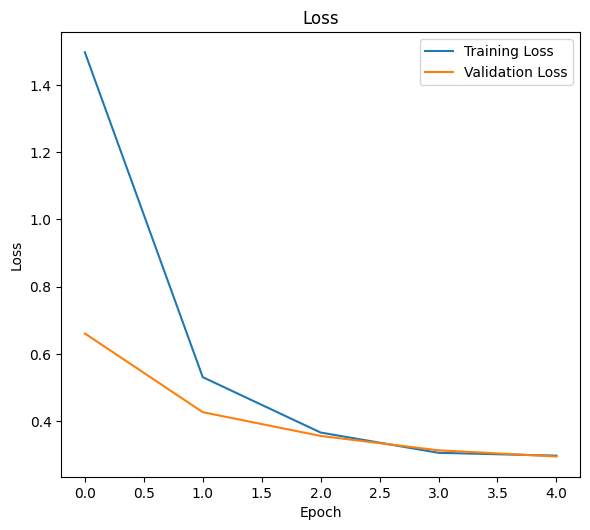

In [ ]:
import matplotlib.pyplot as plt

# Extracting data from history dictionary
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting loss and accuracy
plt.figure(figsize=(6, 10))

plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

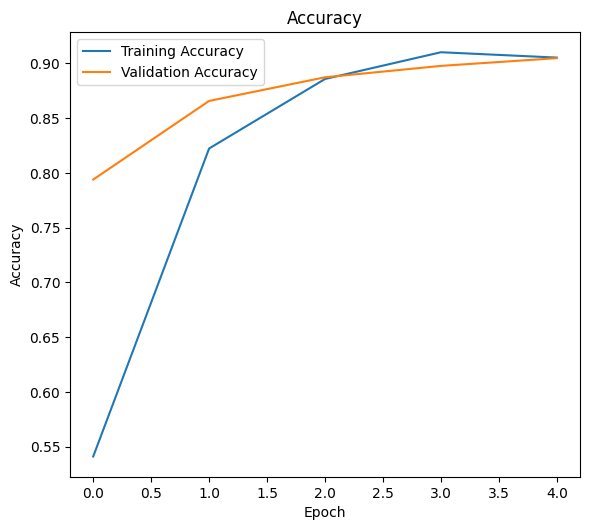

In [ ]:
plt.figure(figsize=(6, 10))

plt.subplot(2, 1, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<Axes: >

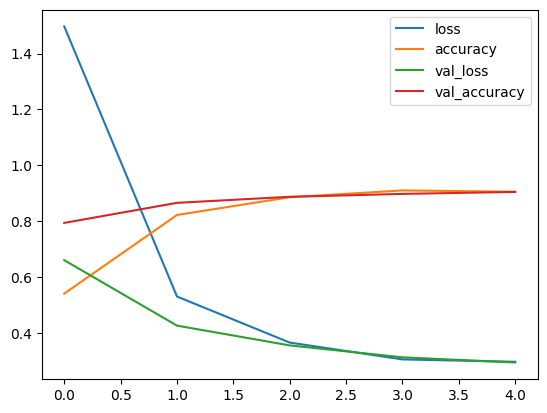

In [ ]:
# Convert history object to pandas DataFrame
history_df = pd.DataFrame(history.history)

# Plot the DataFrame using matplotlib
import matplotlib.pyplot as plt

history_df.plot()
plt.show()

In [ ]:
# Apply the `prepare_validation_data` function to each element in the `test_dataset`
prepared_test_dataset = test_dataset.map(prepare_validation_data)

# Batch the prepared dataset into batches of size `BATCH_SIZE`
batched_test_dataset = prepared_test_dataset.batch(BATCH_SIZE)

In [ ]:
model.evaluate(test_dataset)

22/22 [==============================] - 12s 508ms/step - loss: 0.2712 - accuracy: 0.9170


[0.2712356150150299, 0.9170370101928711]

1/1 [==============================] - 0s 29ms/step


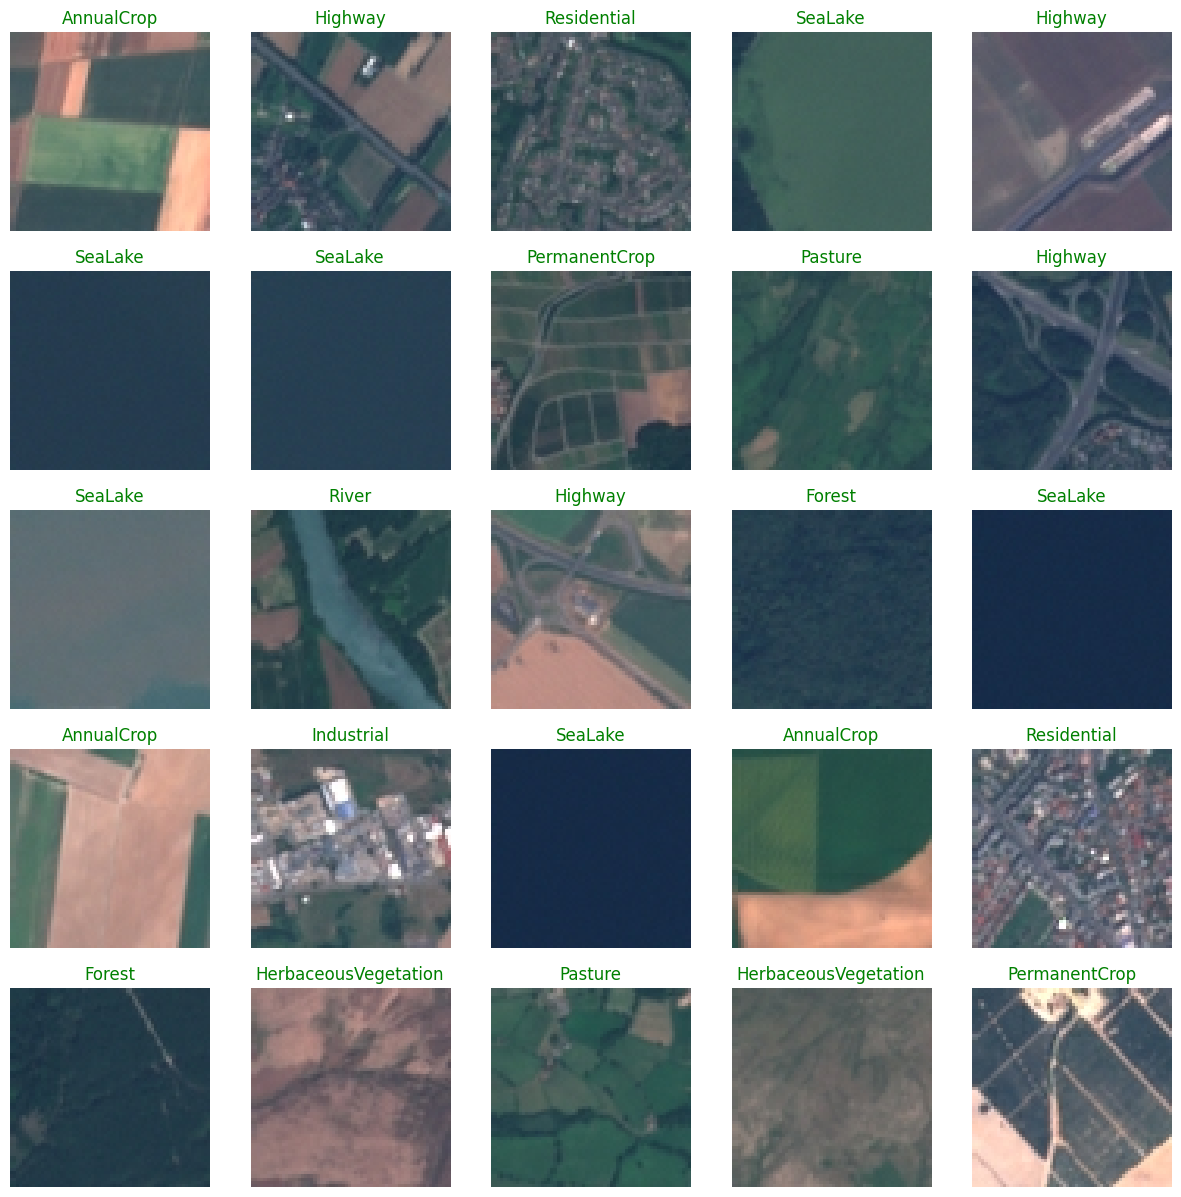

In [ ]:
# Create figure and subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# Iterate through data points
for i, (image, label) in enumerate(test_dataset):
    # Preprocess image
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Get predicted class and title color
    predicted_class = np.argmax(model.predict(image))
    title_color = "green" if predicted_class == label else "red"

    # Add image and title to subplot
    axes[i // 5, i % 5].imshow(image.reshape(IMAGE_SHAPE[:2]))
    axes[i // 5, i % 5].set_title(class_names[predicted_class], color=title_color)

    # Turn off axis labels and ticks
    axes[i // 5, i % 5].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

# DenseNet201

In [ ]:
# Import the DenseNet201 model and preprocess_input function from the TensorFlow Keras applications library
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input

# This will import the DenseNet201 architecture, which is a pre-trained convolutional neural network for image classification.

# The preprocess_input function will preprocess your images before feeding them to the model. This includes operations like normalization, scaling, and resizing.


In [ ]:
# Load pre-trained DenseNet201 with ImageNet weights, excluding top layer
denseNet = DenseNet201(input_shape=IMAGE_SHAPE + [3], weights="imagenet", include_top=False)

# Freeze all pre-trained layers
for layer in denseNet.layers:
  layer.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(denseNet.output)  # Global average pooling
x = Flatten()(x)  # Flatten
x = Dense(512, activation="relu")(x)  # Dense layer with 512 units and ReLU activation
prediction = Dense(NUM_CLASSES, activation="softmax")(x)  # Output layer with softmax activation

# Create the model
model = tf.keras.models.Model(inputs=denseNet.input, outputs=prediction)

# Print model summary
model.summary()

In [ ]:
# Define the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Specify the optimizer
optimizer = tf.keras.optimizers.Adam()

# Define the metrics to track
metrics = ['accuracy']

# Compile the model with the specified loss function, optimizer, and metrics
model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)

In [ ]:
# Define the number of steps per epoch (8)
STEPS_PER_EPOCH = 8

# Calculate the number of validation steps
VALIDATION_STEPS = info.splits["train"].num_examples // BATCH_SIZE
VALIDATION_STEPS = int(VALIDATION_STEPS * 0.1)  # Use 10% of training data for validation

In [ ]:
# Configure the training process
training_config = {
    "epochs": NUM_EPOCHS,  # Number of times to iterate over the entire training dataset
    "steps_per_epoch": STEPS_PER_EPOCH,  # Number of batches to process per epoch
    "validation_data": validation_dataset,  # Dataset to evaluate the model on during training
    "validation_steps": VALIDATION_STEPS,  # Number of batches to process for validation
}

# Train the model and store the training history
history = model.fit(train_dataset, **training_config)

Epoch 1/5
8/8 [==============================] - 58s 4s/step - loss: 1.5488 - accuracy: 0.5010 - val_loss: 0.6998 - val_accuracy: 0.8144
Epoch 2/5
8/8 [==============================] - 17s 2s/step - loss: 0.5290 - accuracy: 0.8477 - val_loss: 0.4392 - val_accuracy: 0.8516
Epoch 3/5
8/8 [==============================] - 16s 2s/step - loss: 0.3602 - accuracy: 0.8760 - val_loss: 0.3415 - val_accuracy: 0.8862
Epoch 4/5
8/8 [==============================] - 16s 2s/step - loss: 0.2774 - accuracy: 0.9102 - val_loss: 0.3262 - val_accuracy: 0.8955
Epoch 5/5
8/8 [==============================] - 25s 3s/step - loss: 0.2475 - accuracy: 0.9258 - val_loss: 0.2734 - val_accuracy: 0.9070


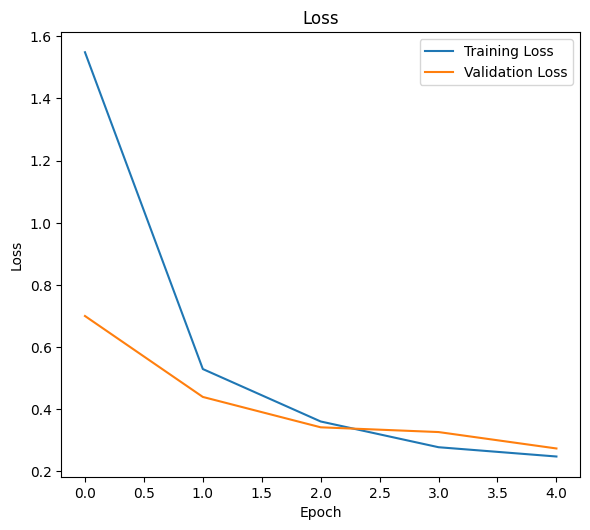

In [ ]:
import matplotlib.pyplot as plt

# Extracting data from history dictionary
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting loss and accuracy
plt.figure(figsize=(6, 10))

plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

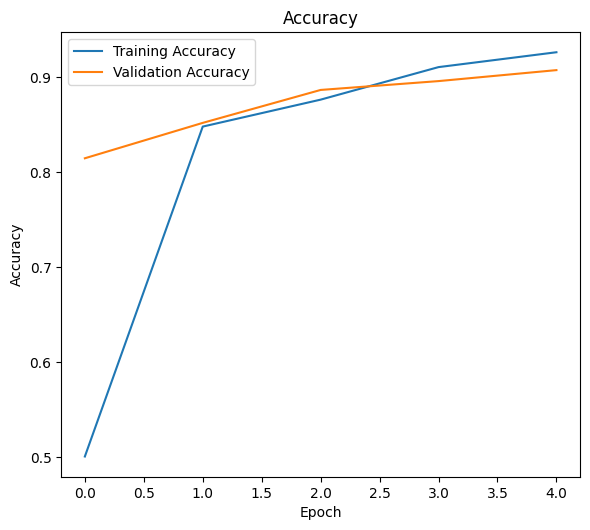

In [ ]:
plt.figure(figsize=(6, 10))

plt.subplot(2, 1, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<Axes: >

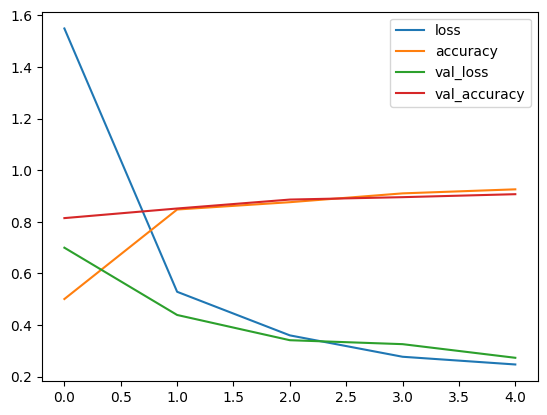

In [ ]:
# Convert history.history dictionary to pandas DataFrame
df = pd.DataFrame(history.history)

# Plot the DataFrame using pandas plot method
df.plot()

In [ ]:
# Apply the `prepare_validation_data` function to each element in the `test_dataset`
test_dataset = test_dataset.map(prepare_validation_data)

# Batch the processed data into batches of size `BATCH_SIZE`
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
model.evaluate(test_dataset)

22/22 [==============================] - 14s 616ms/step - loss: 0.2376 - accuracy: 0.9185


[0.23757195472717285, 0.9185185432434082]

1/1 [==============================] - 0s 36ms/step


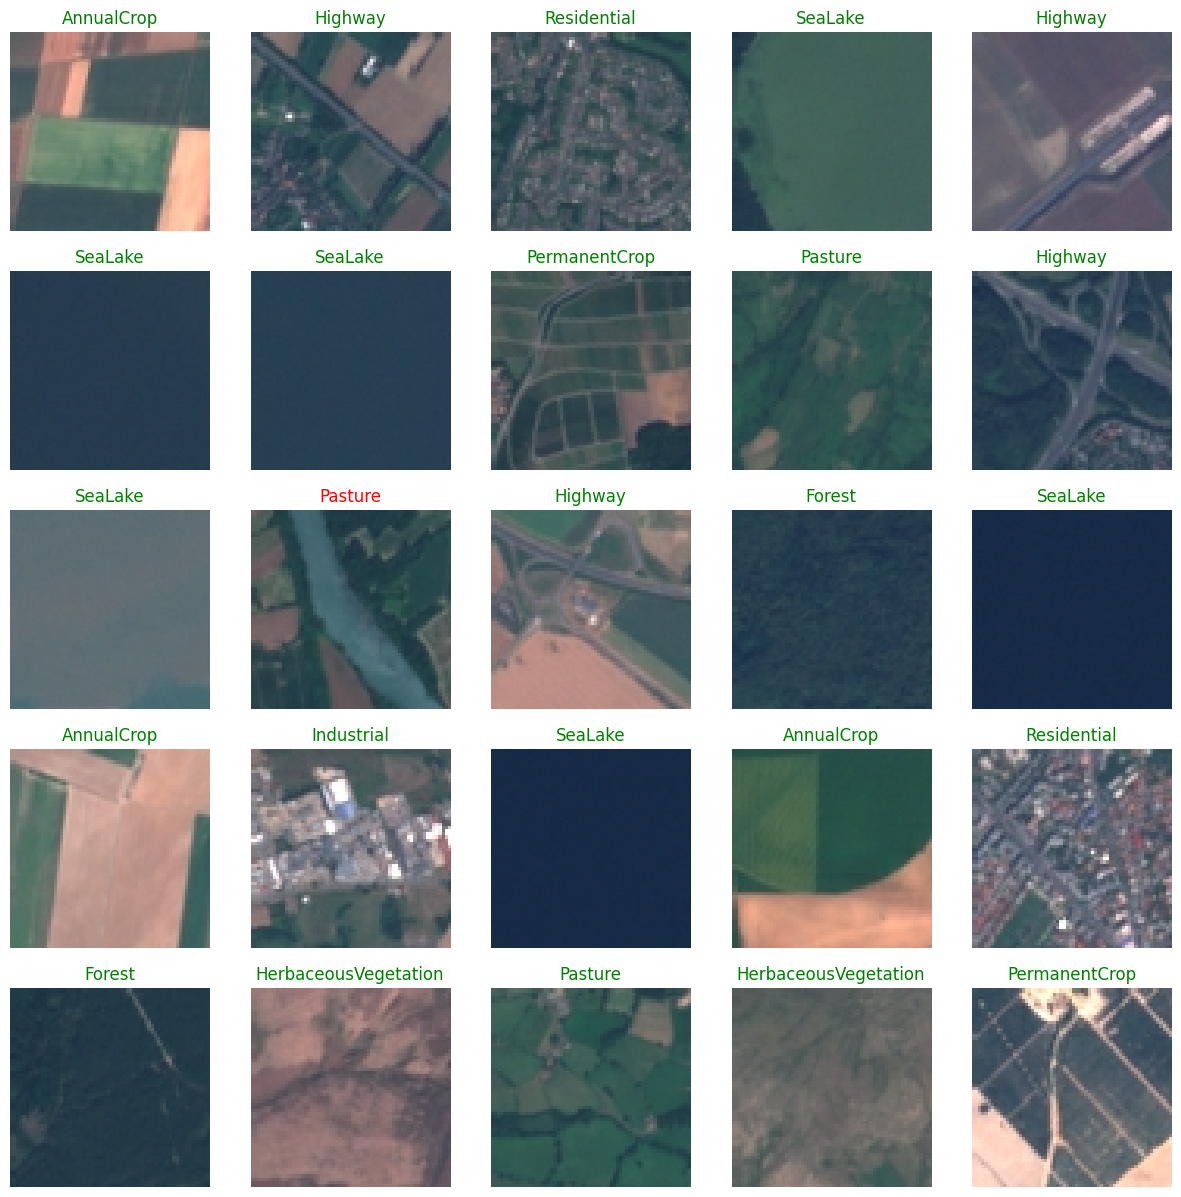

In [ ]:
# Create figure
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# Iterate over 25 datapoints
for i, datapoint in enumerate(tfds.as_numpy(test.take(25))):
    # Get current axis
    ax = axes[i // 5, i % 5]

    # Display image
    ax.imshow(datapoint["image"])

    # Resize image
    resized_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)

    # Preprocess image
    preprocessed_image = preprocess_input(resized_image)

    # Add dimension
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)

    # Predict class
    predicted_class = np.argmax(model.predict(preprocessed_image))

    # Set title color based on accuracy
    if datapoint["label"] == predicted_class:
        title_color = "green"
    else:
        title_color = "red"

    # Set title
    ax.set_title(class_names[predicted_class], color=title_color)

    # Turn off axis visibility
    ax.axis("off")

# Show figure
plt.tight_layout()
plt.show()


# Resnet50

In [ ]:
# Import the ResNet50 architecture and preprocess_input function from Keras applications
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

# ResNet50: This is a pre-trained convolutional neural network architecture for image classification.
# preprocess_input: This function preprocesses images for input into ResNet50. It includes:
# - Converting RGB images to BGR format.
# - Zero-centering each color channel with respect to the ImageNet dataset.

In [ ]:
# Create the base ResNet50 model with pre-trained weights
resnet = ResNet50(
    input_shape=IMAGE_SHAPE + [3],
    weights="imagenet",
    include_top=False  # exclude the pre-trained top layers
)

In [ ]:
# Freeze all layers in the base model to prevent them from being updated during training
for layer in resnet.layers:
    layer.trainable = False

In [ ]:
# Add additional layers for fine-tuning
x = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)  # average pooling over spatial dimensions
x = tf.keras.layers.Flatten()(x)  # flatten the output into a single vector
x = tf.keras.layers.Dense(512, activation="relu")(x)  # add a dense layer with 512 units and ReLU activation
prediction = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)  # output layer with NUM_CLASSES units and softmax activation

In [ ]:
# Create the final model
model = tf.keras.models.Model(
    inputs=resnet.input,  # use the input layer of the base model
    outputs=prediction  # use the prediction layer as the model output
)

In [ ]:
# Define the loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Define the optimizer
optimizer = tf.keras.optimizers.Adam()
# Define the metrics
metrics = ['accuracy']

# Compile the model
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics
)

In [ ]:
STEPS_PER_EPOCH = 10
VALIDATION_STEPS = 30

In [ ]:
# Train the model
history = model.fit(
    # Train data
    train_dataset,
    # Number of epochs to train for
    epochs=NUM_EPOCHS,
    # Number of steps per epoch (optional)
    steps_per_epoch=STEPS_PER_EPOCH,
    # Validation data
    validation_data=validation_dataset,
    # Number of validation steps per epoch (optional)
    validation_steps=VALIDATION_STEPS
)

Epoch 1/6
10/10 [==============================] - 29s 1s/step - loss: 1.1769 - accuracy: 0.6266 - val_loss: 0.4264 - val_accuracy: 0.8656
Epoch 2/6
10/10 [==============================] - 12s 1s/step - loss: 0.3064 - accuracy: 0.8953 - val_loss: 0.3048 - val_accuracy: 0.9044
Epoch 3/6
10/10 [==============================] - 13s 1s/step - loss: 0.2560 - accuracy: 0.9133 - val_loss: 0.2550 - val_accuracy: 0.9174
Epoch 4/6
10/10 [==============================] - 12s 1s/step - loss: 0.2222 - accuracy: 0.9289 - val_loss: 0.2251 - val_accuracy: 0.9268
Epoch 5/6
10/10 [==============================] - 13s 1s/step - loss: 0.2094 - accuracy: 0.9305 - val_loss: 0.2196 - val_accuracy: 0.9234
Epoch 6/6
10/10 [==============================] - 12s 1s/step - loss: 0.2097 - accuracy: 0.9305 - val_loss: 0.2104 - val_accuracy: 0.9289


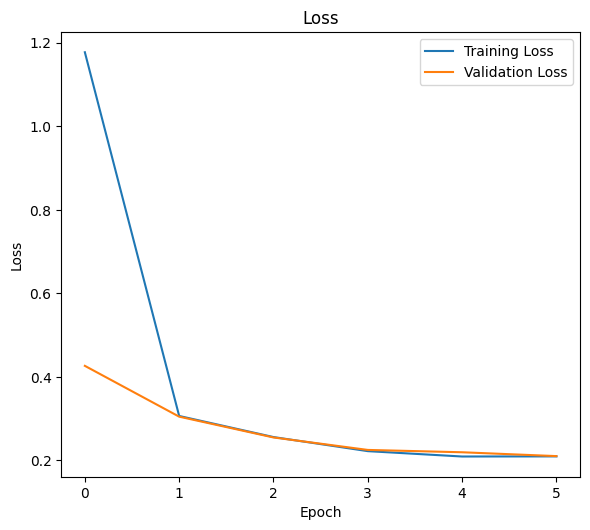

In [ ]:
import matplotlib.pyplot as plt

# Extracting data from history dictionary
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting loss and accuracy
plt.figure(figsize=(6, 10))

plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

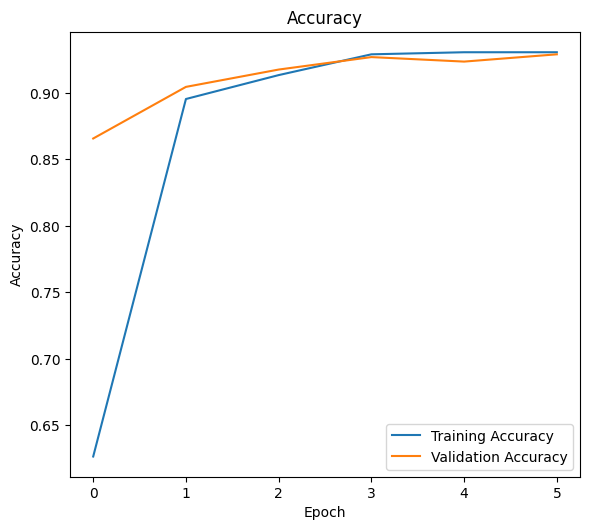

In [ ]:
plt.figure(figsize=(6, 10))

plt.subplot(2, 1, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<Axes: >

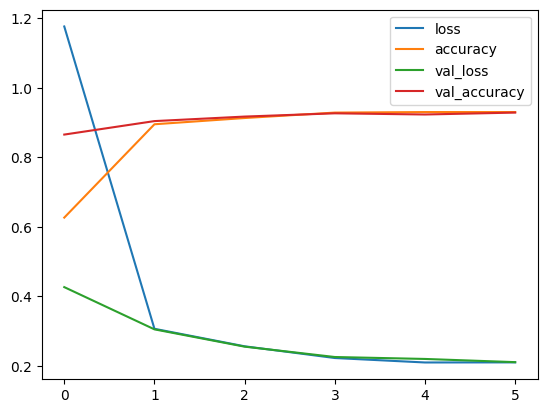

In [ ]:
# Convert the history.history dictionary to a Pandas DataFrame
df_history = pd.DataFrame(history.history)

# Plot the data in the DataFrame
df_history.plot()

# Optionally, you can customize the plot using matplotlib
# For example, to set the title and labels of the plot axes
df_history.plot(title="Model Training History", ylabel="Loss")

In [ ]:
# Apply the prepare_validation_data function to each element in the test dataset
# This function preprocesses the data for validation
test_dataset = test.map(prepare_validation_data)

# Batch the preprocessed validation data into batches of size BATCH_SIZE
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
model.evaluate(test_dataset)

22/22 [==============================] - 7s 275ms/step - loss: 0.2000 - accuracy: 0.9341


[0.20003074407577515, 0.9340741038322449]

1/1 [==============================] - 0s 39ms/step


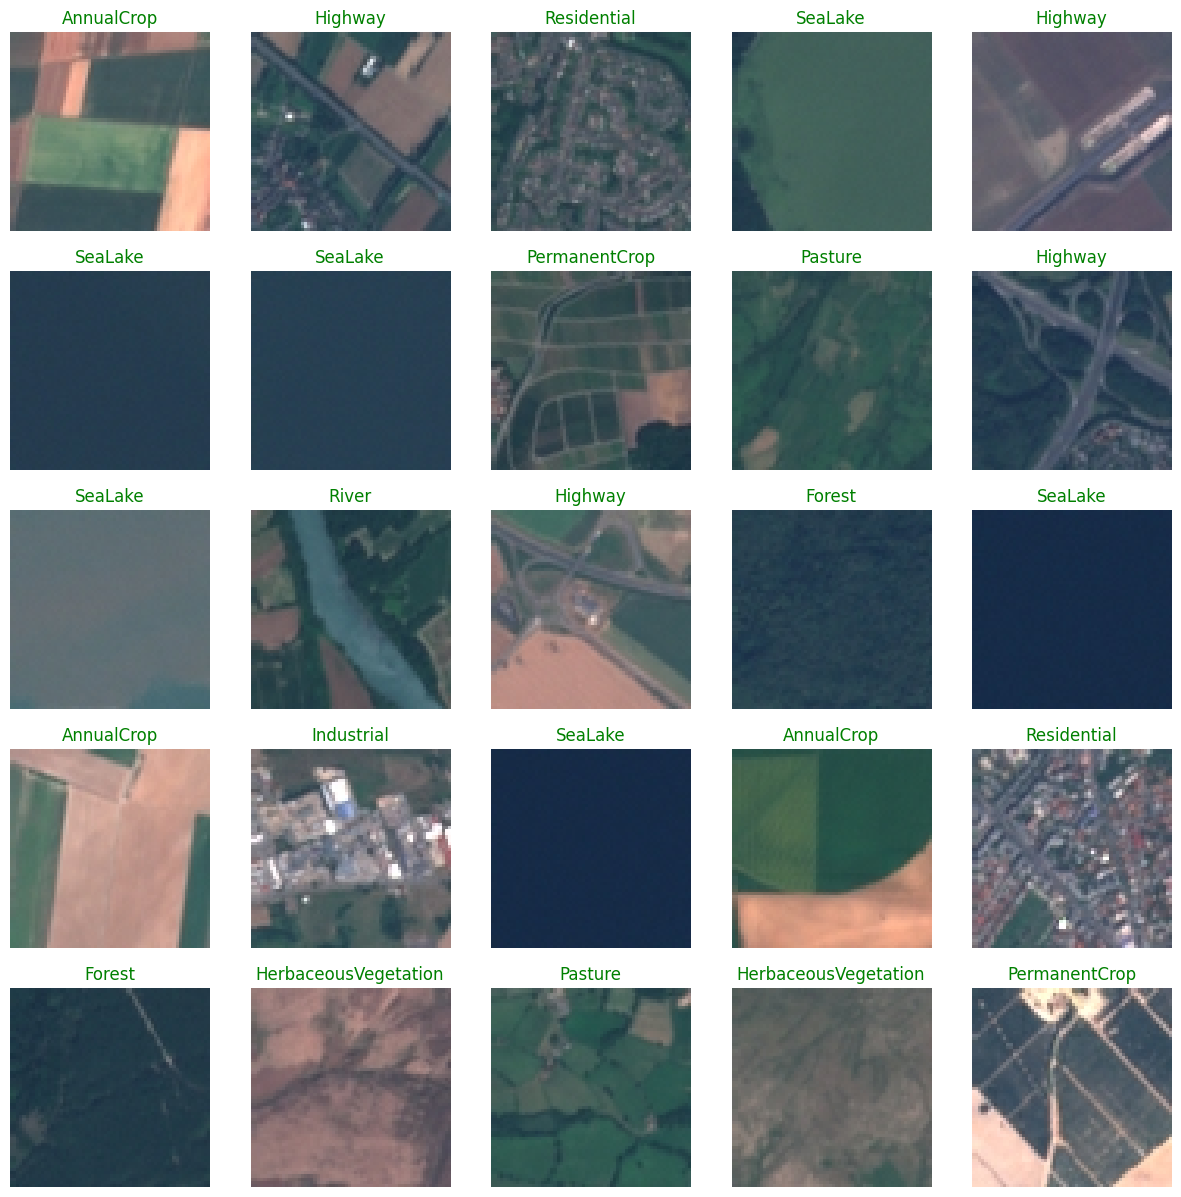

In [ ]:
# Create a 5x5 subplot grid
plt.figure(figsize=(15, 15))

# Loop through each data point
for i, datapoint in enumerate(datapoints):
  # Define current subplot
  ax = plt.subplot(5, 5, i+1)

  # Display original image
  plt.imshow(datapoint["image"])

  # Preprocess image for model prediction
  resized_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  preprocessed_image = preprocess_input(resized_image)
  expanded_image = np.expand_dims(preprocessed_image, axis=0)

  # Predict class and compare with ground truth
  predicted_class = np.argmax(model.predict(expanded_image))
  ground_truth = datapoint["label"]

  # Set title based on prediction and ground truth
  plt.title(class_names[predicted_class], color="green" if predicted_class == ground_truth else "red")

  # Turn off axes for cleaner visualization
  plt.axis("off")

# Display the complete plot
plt.show()